# Benchmark: Koalas (PySpark) and Dask - Local execution summary
The benchmark was performed against the 2009 - 2013 Yellow Taxi Trip Records (157 GB) from NYC Taxi and Limousine Commission (TLC) Trip Record Data.

The benchmark results below explain the performance differences between Koalas and Dask. Because the Koalas APIs are written on the top of PySpark, the results of this benchmark would apply similarly to PySpark.

## Preparation

In [9]:
DATASETS_DIR = '../../datasets'

In [10]:
import pandas as pd
from scipy import stats
import os
 
def fair_avg(durations):
  """Get an average duration among multiple durations fairly by removing the first run and the best run first."""
  durations = durations[1:] 
  durations.remove(min(durations))
  return sum(durations) / len(durations)
 
def rename_index(df):
  """Rename operations in the average result dataframe for clarity."""
  df.index = map(
    lambda s: s.replace("filtered ", "")
      .replace("of columns", "of series")
      .replace("addition of series", "series addition")
      .replace("multiplication of series", "series multiplication")
      .replace("arithmetic ops", "arithmetic")
      .replace("count index length", "count index"),
    df.index)
  return df
 
def avg_result_df(file_name_prefix):
  """Get result files with the given prefix and then construct the average result dataframe."""
  dfs = []
  file_infos = os.listdir(f'{DATASETS_DIR}/../results/koalas-benchmark-no-parquet-cache')
  for file_info in file_infos:
    if file_info.startswith(file_name_prefix):
      dfs.append(pd.read_parquet(f'{DATASETS_DIR}/../results/koalas-benchmark-no-parquet-cache/%s' % file_info))
  print(f'{file_name_prefix} has {len(dfs)} runs')    
  
  avg_df = dfs[0].copy()
  for op in dfs[0].index:
    for lib in ['koalas', 'dask']:
      durations = []
      for df in dfs:
        durations.append(df.loc[op][lib])
      avg_df.loc[op][lib] = fair_avg(durations)
      
  return rename_index(avg_df)
 
def annotate(ax):
  """Annotate the height of each bar in the plot."""
  for p in ax.patches:
    ax.annotate("%.2fs" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
 
def annotate_x_times_faster(ax, x_times_list):
  """Annotate Koalas is how many times faster per operation in the plot."""
  num_ops = len(x_times_list)
  for i, p in enumerate(ax.patches):
    if i < num_ops:  # The first half of ax.patches of Koalas; we only annotate Koalas patches
      ax.annotate("%.1fx" % x_times_list[i], (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(4, 10), textcoords='offset points', fontsize=8, weight='bold', color="#585858")
 
local_res_df = avg_result_df('single_node_')
local_res_df.columns = ['Koalas (PySpark)', 'Dask']
standard_ops = local_res_df.iloc[:12]
ops_with_filtering = local_res_df.iloc[12:]

single_node_ has 3 runs


## Standard operations

Text(0, 0.5, 'Elapsed time (sec)')

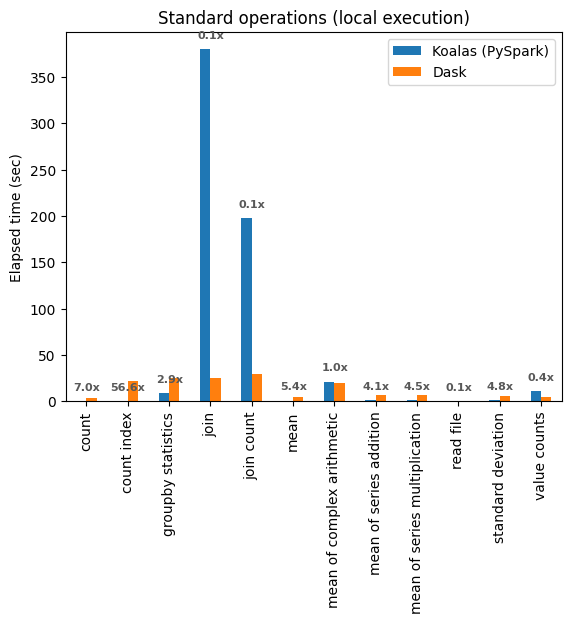

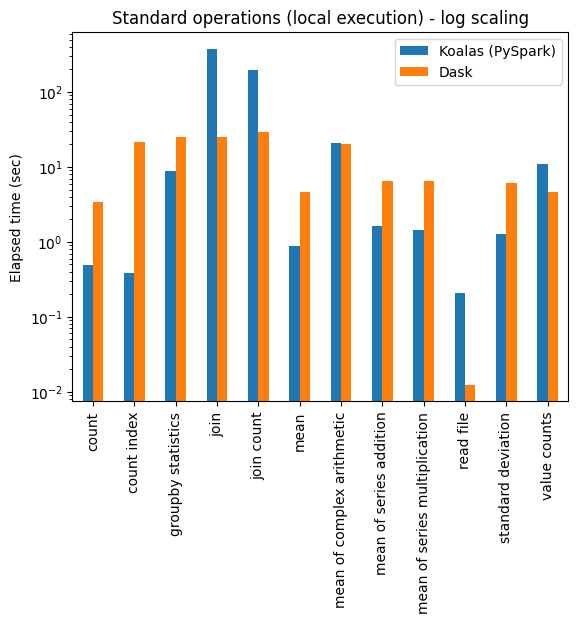

In [11]:
plot_title = 'Standard operations (local execution)'
 
ax = standard_ops.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")
 
tmp_df_x_times_faster = standard_ops.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())
 
standard_ops.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [12]:
tmp_df_x_times_faster

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
count,0.487278,3.402935,6.983564,0.143193
count index,0.383518,21.706681,56.598826,0.017668
groupby statistics,8.751947,25.221879,2.881859,0.346998
join,379.675690,25.331951,0.066720,14.988016
join count,197.555428,29.049069,0.147043,6.800749
mean,0.874035,4.680126,5.354622,0.186755
mean of complex arithmetic,21.132065,20.302884,0.960762,1.040841
mean of series addition,1.620907,6.579668,4.059251,0.246351
mean of series multiplication,1.440864,6.468386,4.489242,0.222755
read file,0.205926,0.012467,0.060542,16.517489


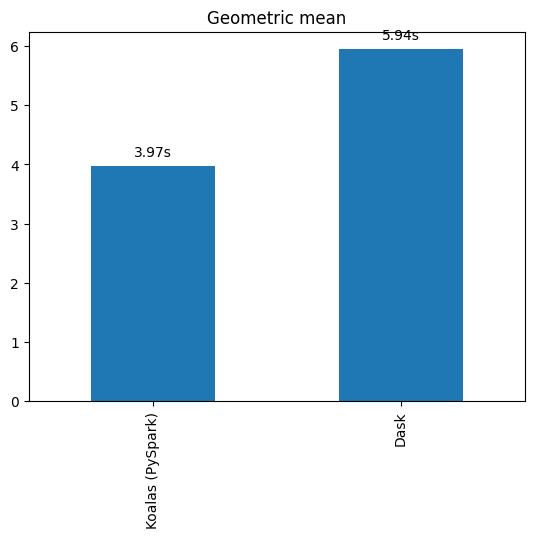

In [13]:
annotate(pd.Series(stats.gmean(standard_ops), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

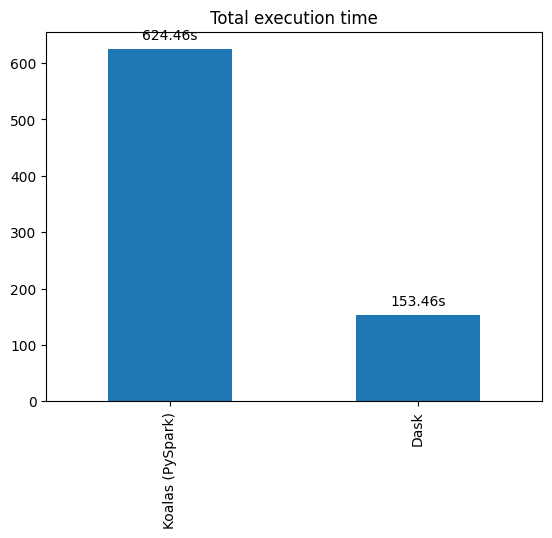

In [14]:
annotate(standard_ops.sum().plot.bar(title='Total execution time'))

In [15]:
print("Performance diff %% (simple avg): %s" % (sum(standard_ops.Dask / standard_ops['Koalas (PySpark)']) / len(standard_ops)))
print("Performance diff %% (geomean): %s" % stats.gmean(standard_ops.Dask / standard_ops['Koalas (PySpark)']))
 
# basic_stats_ops = standard_ops.filter(items=['count', 'mean', 'standard deviation', 'count index', 'join', 'join count'], axis=0)
# print("Performance diff (basic stats) %% (simple avg): %s" % (sum(basic_stats_ops.Dask / basic_stats_ops['Koalas (PySpark)']) / len(basic_stats_ops)))
# print("Performance diff (basic stats) %% (geomean): %s" % stats.gmean(basic_stats_ops.Dask / basic_stats_ops['Koalas (PySpark)']))

Performance diff % (simple avg): 7.232320627577303
Performance diff % (geomean): 1.4980042578072608


## Operations with filtering

Text(0, 0.5, 'Elapsed time (sec)')

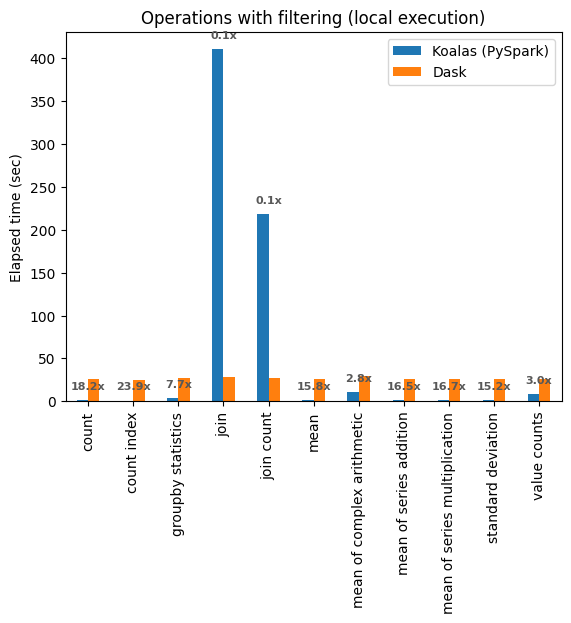

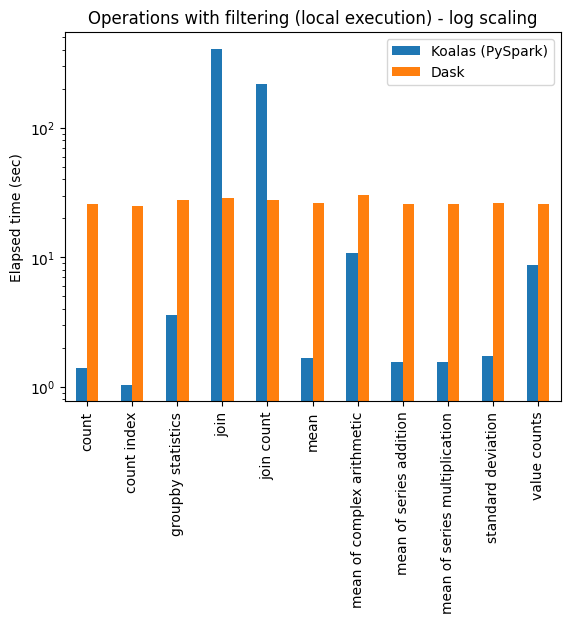

In [16]:
plot_title = 'Operations with filtering (local execution)'
 
ax = ops_with_filtering.sort_index().plot.bar(title=plot_title)
ax.set_ylabel("Elapsed time (sec)")
 
tmp_df_x_times_faster = ops_with_filtering.sort_index().copy()
tmp_df_x_times_faster['Dask / Koalas'] = tmp_df_x_times_faster.Dask / tmp_df_x_times_faster['Koalas (PySpark)']
tmp_df_x_times_faster['Koalas / Dask'] = tmp_df_x_times_faster['Koalas (PySpark)'] / tmp_df_x_times_faster.Dask
annotate_x_times_faster(ax, x_times_list=tmp_df_x_times_faster['Dask / Koalas'].to_list())
 
ops_with_filtering.sort_index().plot.bar(logy=True, title='%s - log scaling' % plot_title).set_ylabel("Elapsed time (sec)")

In [17]:
tmp_df_x_times_faster

,Koalas (PySpark),Dask,Dask / Koalas,Koalas / Dask
count,1.408208,25.656851,18.219505,0.054886
count index,1.040714,24.860189,23.887633,0.041863
groupby statistics,3.598891,27.603912,7.670116,0.130376
join,409.780593,28.791604,0.070261,14.232642
join count,217.960234,27.612762,0.126687,7.893460
mean,1.664776,26.241297,15.762656,0.063441
mean of complex arithmetic,10.738772,30.063212,2.799502,0.357206
mean of series addition,1.560645,25.802118,16.532985,0.060485
mean of series multiplication,1.551131,25.857634,16.670186,0.059987
standard deviation,1.732065,26.413559,15.249749,0.065575


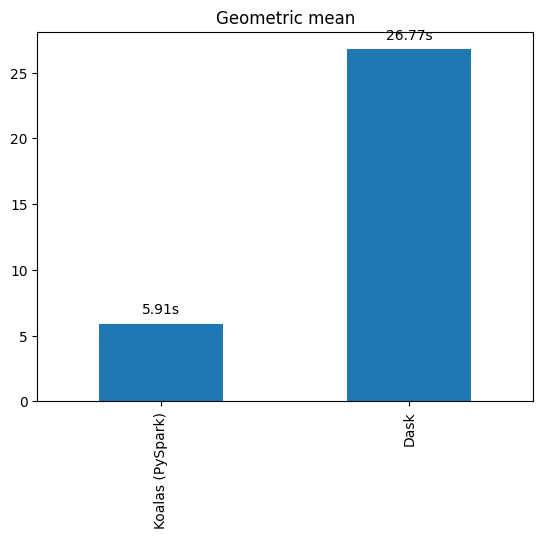

In [18]:
annotate(pd.Series(stats.gmean(ops_with_filtering), index=['Koalas (PySpark)', 'Dask']).plot.bar(title='Geometric mean'))

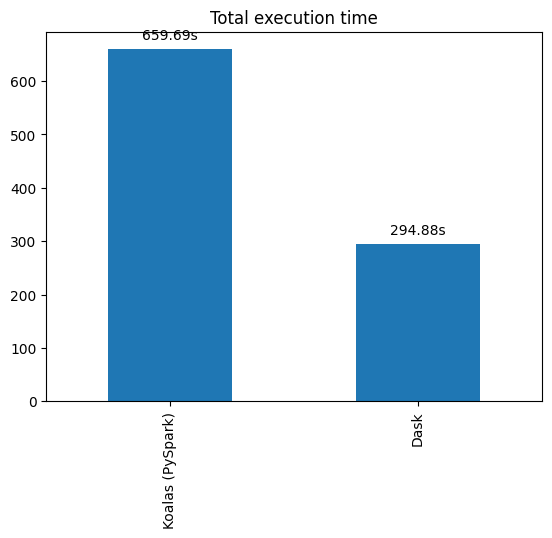

In [19]:
annotate(ops_with_filtering.sum().plot.bar(title='Total execution time'))

In [20]:
print("Performance diff %% (simple avg): %s" % (sum(ops_with_filtering.Dask / ops_with_filtering['Koalas (PySpark)']) / len(ops_with_filtering)))
print("Performance diff %% (geomean): %s" % stats.gmean(ops_with_filtering.Dask / ops_with_filtering['Koalas (PySpark)']))

Performance diff % (simple avg): 10.90817085860506
Performance diff % (geomean): 4.531281381186608


## Overall

In [21]:
overall_df = pd.concat([standard_ops, ops_with_filtering])
print("Total performance diff %% (simple avg): %s" % (sum(overall_df.Dask / overall_df['Koalas (PySpark)']) / len(overall_df)))
print("Total performance diff %% (geomean): %s" % stats.gmean(overall_df.Dask / overall_df['Koalas (PySpark)']))

Total performance diff % (simple avg): 8.990335955460141
Total performance diff % (geomean): 2.543412879282152
